# Stock Prediction 

In [1]:
#In this program we must be able to take the stock price of any company and predict its price by using LSTM. 

In [2]:
#first we import the libraries that we will be requiring 
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM 
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
plt.style.use('ggplot')

In [3]:
#mention the company whose data we want to analyze 
company = 'AMZN' #company name = Amazon
#mention the start time from when the data is analyzed 
#datetime format is YYYY,MM,DD
start = dt.datetime(2018,1,1)
#mention the last date at which the data anylysis is stopped
end = dt.datetime(2023,1,1)
#create dataframe and from yahoo finance download the company stock data from the timeline mentioned 
dataFrame = yf.download(company, start, end)
#print statement 
print(dataFrame)

[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2018-01-02  58.599998  59.500000  58.525501  59.450500  59.450500  53890000
2018-01-03  59.415001  60.274502  59.415001  60.209999  60.209999  62176000
2018-01-04  60.250000  60.793499  60.233002  60.479500  60.479500  60442000
2018-01-05  60.875500  61.457001  60.500000  61.457001  61.457001  70894000
2018-01-08  61.799999  62.653999  61.601501  62.343498  62.343498  85590000
...               ...        ...        ...        ...        ...       ...
2022-12-23  83.250000  85.779999  82.930000  85.250000  85.250000  57433700
2022-12-27  84.970001  85.349998  83.000000  83.040001  83.040001  57284000
2022-12-28  82.800003  83.480003  81.690002  81.820000  81.820000  58228600
2022-12-29  82.870003  84.550003  82.550003  84.180000  84.180000  54995900
2022-12-30  83.1200

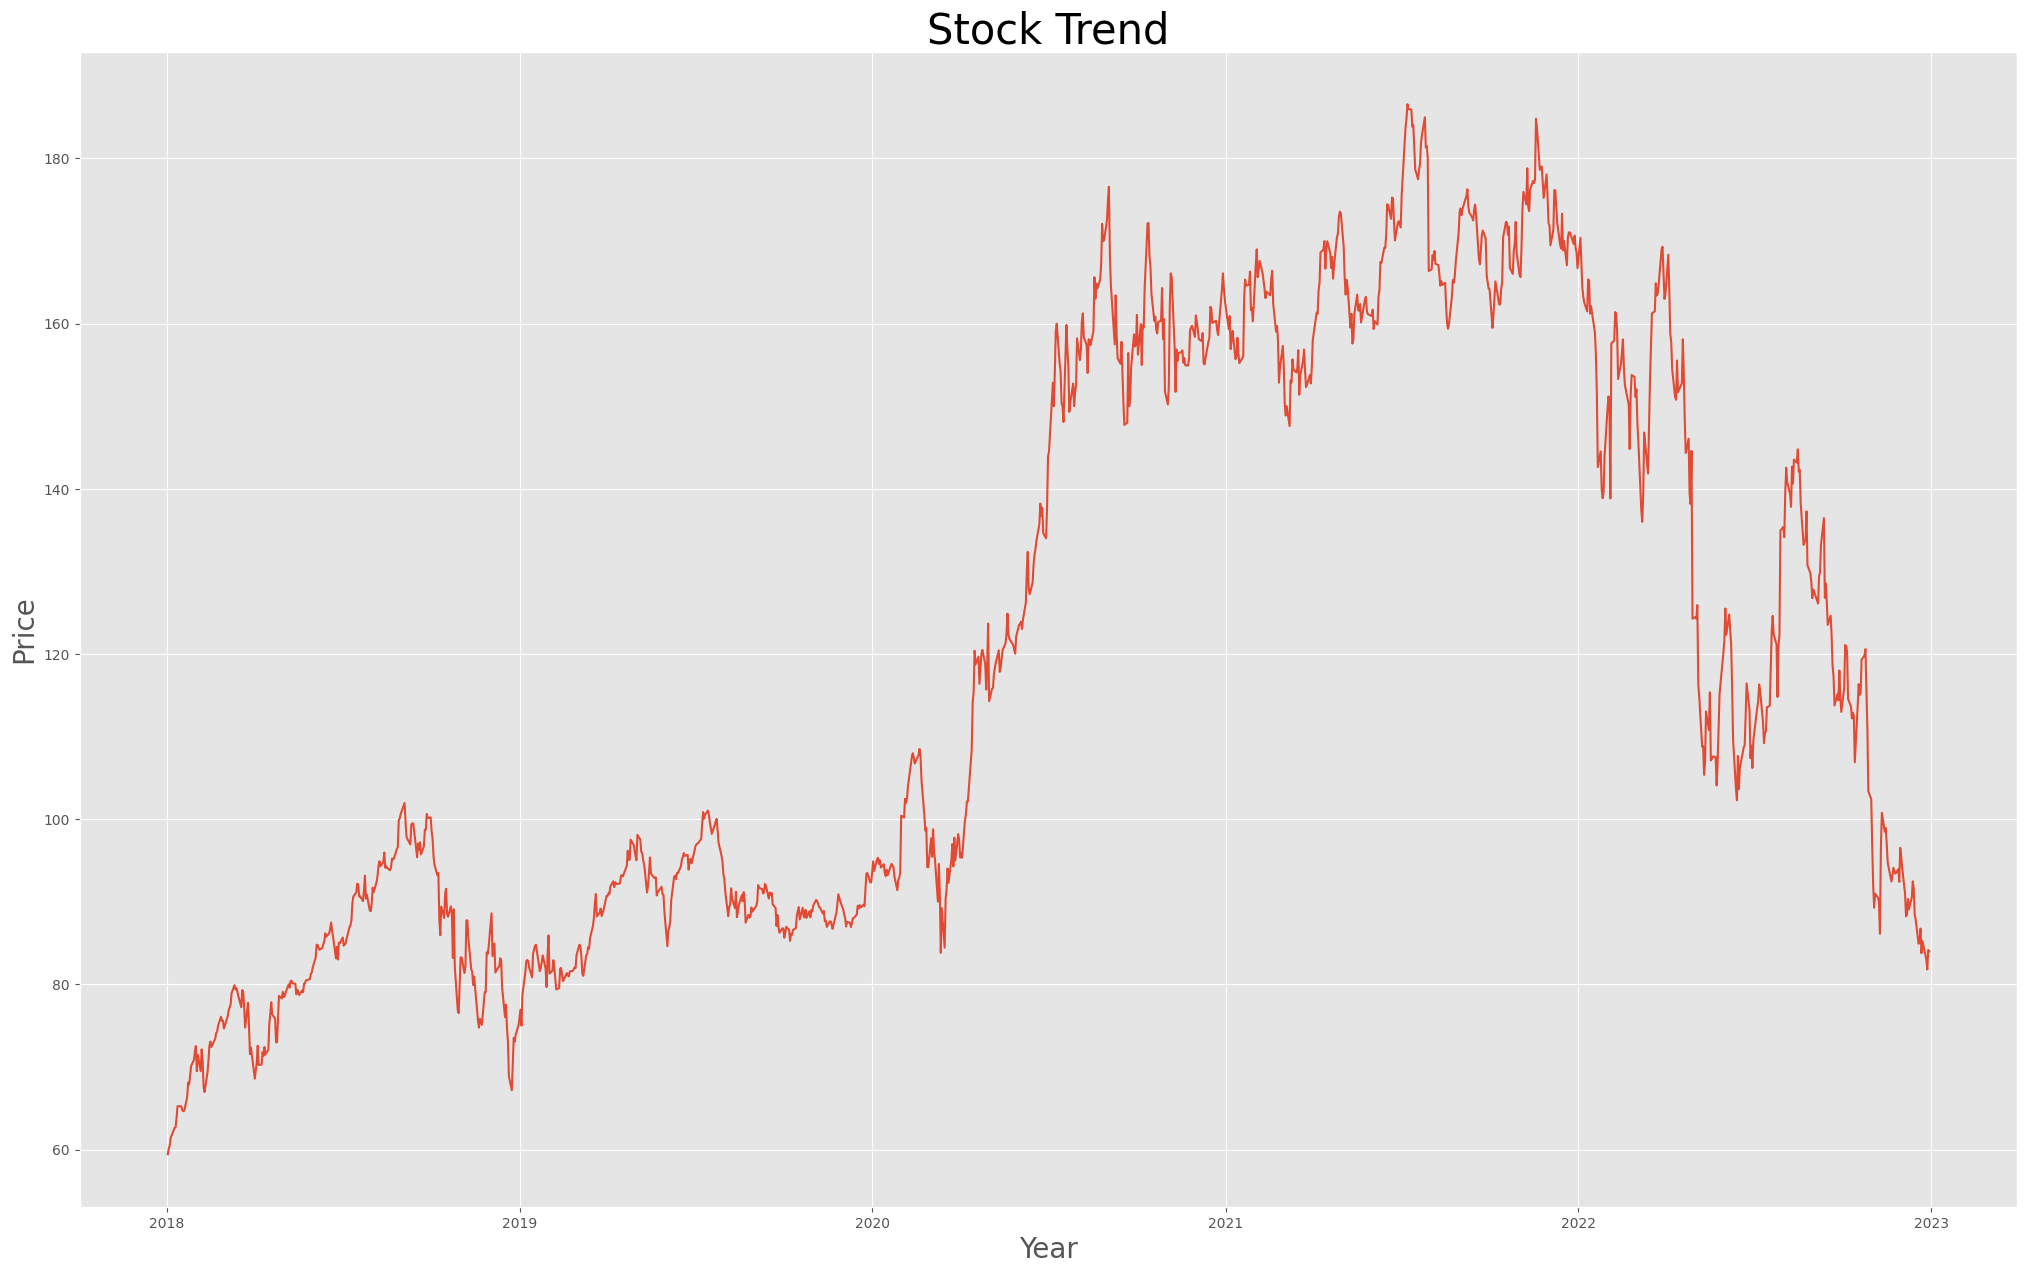

In [4]:
#creating a visual representation of the stock trend based on data received 
#figure is a demonstration fihure 
plt.figure(figsize=(25,15))
#mention the title of the graph 
plt.title('Stock Trend',fontsize=30)
#mention what data from the dataFrame do we want the represntation of 
plt.plot(dataFrame['Close'])
#mention the title of the x axis of the graph
plt.xlabel('Year',fontsize=20)
#mention the title of the y axis of the graph
plt.ylabel('Price',fontsize=20)
#display the graph 
plt.show()

In [5]:
#create a new dataframe with only one column of specific data (Closing price)
data = dataFrame.filter(['Close'])
#convert the data into a numpy array
dataArr = data.values
#mention the number of rows of data to be analyzed
training_data_len=math.ceil(len(dataArr)*.8)
#print satatement  
print(training_data_len)

1008


In [6]:
#scaling the data 
#we are scaling the values between 0 and 1 (including 0 and 1) which is our feature range
scaler = MinMaxScaler(feature_range=(0,1))
#we create a dataset from the data that is now scaled 
#compute minimum and maximum of the scaled data and transforms them into a dataset
scaledData = scaler.fit_transform(dataArr)
#print statement 
print(scaledData)

[[0.        ]
 [0.00597466]
 [0.00809471]
 ...
 [0.17597152]
 [0.19453666]
 [0.19312068]]


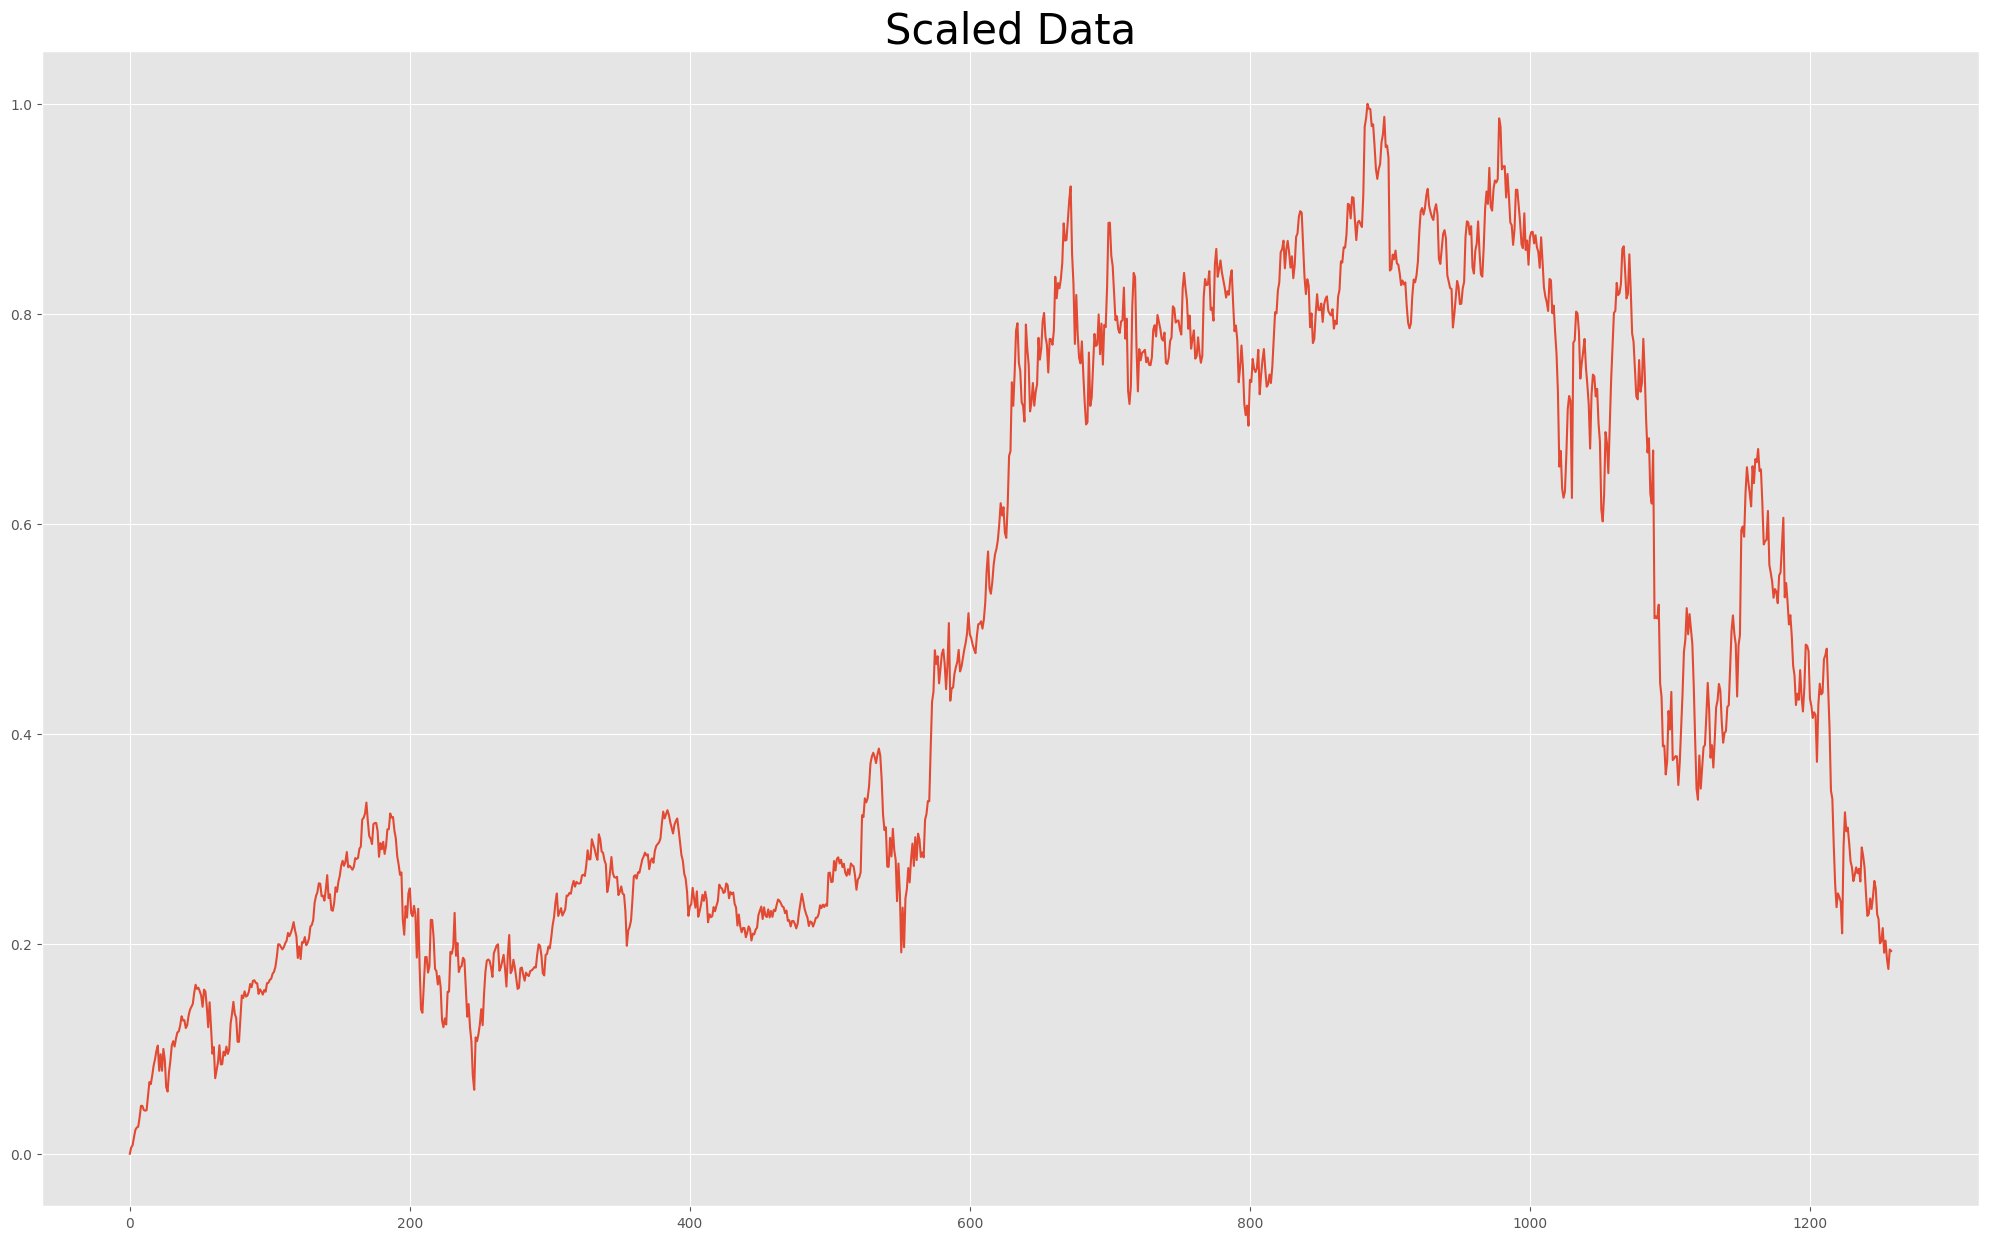

In [7]:
#visualize the scaled data 
plt.figure(figsize=(25,15))
plt.title('Scaled Data',fontsize=30)
plt.plot(scaledData)
plt.show()

In [8]:
#we create a list of days to predict
predictionDays = 30
#create a list of lists that will hold data for each day in training set with initial value as empty
x_train = []
y_train = []
#loop through this list and append scaled data to x_train and y_train 
for x in range(predictionDays, len(scaledData)):
    x_train.append(scaledData[x-predictionDays:x,0])
    y_train.append(scaledData[x,0])

In [9]:
#Convert x_train and y_train into numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [10]:
#display number of samples as rows and number of time stepss as columns 
print(x_train.shape)

(1229, 30)


In [11]:
#Reshaping the data from 2D numpy array into a 3D sequence as required by the LSTM model 
#reshape into 3 dimentions- number of samples, number of prediction days or time stamps and number of features 
#we take the value of 0 and 1 in x_train (0,1) = (rows,columns)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape)

(1229, 30, 1)


In [12]:
#Building the LSTM Model
#we start by creating a sequential model which is base class for all models in keras
model = Sequential()
#add an LSTM layer with 50 units
#return_sequence=True means each time a prediction is made it will also output its previous state
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
#add another LSTM layer 
#return_sequence=False means when a prediction is made, it will not output its previous state 
model.add(LSTM(50, return_sequences=False))
#2 dense layers are added- one with 25 units and one with 1 unit
model.add(Dense(25))
model.add(Dense(1))

In [13]:
#Compile the model
model.compile(optimizer='adam',loss='mean_squared_error')

In [14]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

1229/1229 [==============================] - 16s 8ms/step - loss: 0.0052


In [15]:
#Load test data that is new and the model has no analysis on 
testStart = dt.datetime(2023,1,1)
testEnd = dt.datetime.now()
testData = yf.download(company, testStart, testEnd)
#extract closing prices from data and stored in actualPrices 
actualPrices = testData['Close'].values
#concat the predicted and actual prices 
PredAndActual = pd.concat((data['Close'],testData['Close']),axis=0)
modelInputs = PredAndActual[len(PredAndActual)-len(testData)- predictionDays:].values
#reshape the data and scale it 
modelInputs = modelInputs.reshape(-1,1)
modelInputs = scaler.transform(modelInputs)

[*********************100%***********************]  1 of 1 completed


In [16]:
#Create a data set for testing values
#Create a new array containing scaled values from index 2598 to 2628 (30 prediction days)
testData = scaledData[training_data_len-30: , :]
#Create the data sets for each x_test and y_test
x_test = []
#y_test dataset is for all the values that we want to predict 
y_test = dataArr[training_data_len: , :]
for i in range(30, len(modelInputs)):
    x_test.append(modelInputs[i-30:i, 0])

In [17]:
#Convert the data into a numpy array 
x_test = np.array(x_test)
#Reshape the numpy array to convert it from 2D to 3D for NMST model
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Predictions

In [18]:
#Get predicted price values of company in market
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

4/4 [==============================] - 1s 7ms/step


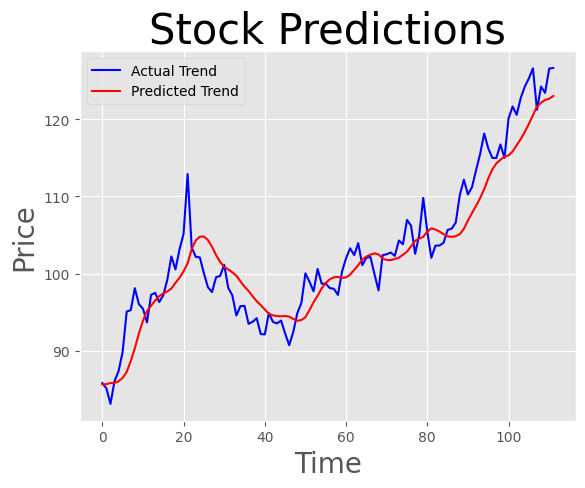

In [19]:
#Plot the predicted data
plt.plot(actualPrices,color='blue',label='Actual Trend')
plt.plot(predictions,color='red',label='Predicted Trend')
plt.title('Stock Predictions',fontsize=30)
plt.xlabel('Time',fontsize=20)
plt.ylabel('Price',fontsize=20)
plt.legend()
plt.show()

In [20]:
#Predict into the future of the value of comapny in stock market
realData = [modelInputs[len(modelInputs)+ 1 - predictionDays:len(modelInputs+1),0]]
realData = np.array(realData)
realData = np.reshape(realData, (realData.shape[0],realData.shape[1],1))
#create our prediction value using model's predict function 
prediction = model.predict(realData)
prediction = scaler.inverse_transform(prediction)
#print statement 
print("Prediction:", prediction)

1/1 [==============================] - 1s 646ms/step
Prediction: [[123.44024]]
